C:\Users\supakron\AppData\Local\Temp\ipykernel_34524\4073418213.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fw_features[feature] = fw_features[feature] * weight
C:\Users\supakron\AppData\Local\Temp\ipykernel_34524\4073418213.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fw_data['Predicted Role'] = kmeans.fit_predict(fw_features_scaled)
C:\Users\supakron\AppData\Local\Temp\ipykernel_34524\4073418213.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

                      Name  Appearances  Goals  Shots on target  \
7           Elijah Adebayo         27.0   10.0             14.0   
9            Simon Adingra         31.0    6.0             22.0   
34          Julián Álvarez         36.0   11.0             40.0   
37            Zeki Amdouni         34.0    5.0             22.0   
55           Taiwo Awoniyi         20.0    6.0             11.0   
57             Jordan Ayew         35.0    4.0             20.0   
61         Michail Antonio         26.0    6.0             14.0   
62                  Antony         29.0    1.0             16.0   
65          Cameron Archer         30.0    4.0             11.0   
104          Saïd Benrahma         13.0    0.0              6.0   
111                   Beto         30.0    3.0             13.0   
129           Jarrod Bowen         34.0   16.0             37.0   
133           Ben Brereton         14.0    6.0             19.0   
134         Rhian Brewster         13.0    0.0              3.

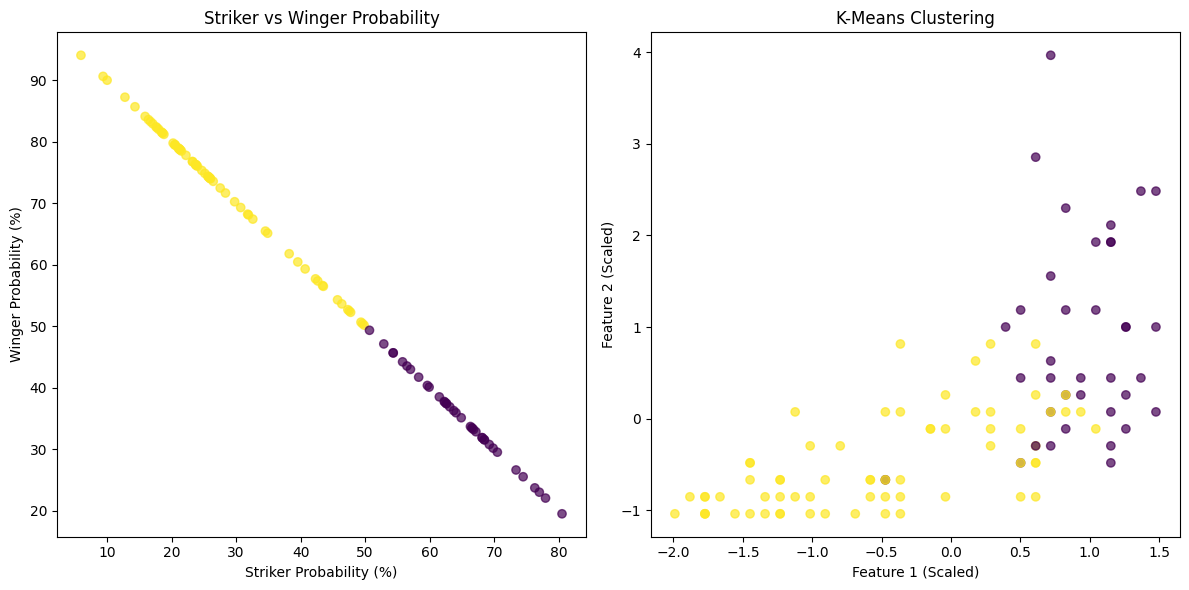

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. นำเข้าข้อมูล
file_path = '../dataset/DatasetFullState.csv'
data = pd.read_csv(file_path)

# ฟังก์ชันเพื่อจัดกลุ่มตำแหน่งนักเตะ
def categorize_position(position):
    if position == 'Goalkeeper':
        return 'Goalkeeper'
    elif position == 'Defender':
        return 'Defender'
    elif position == 'Midfielder':
        return 'Midfielder'
    elif position == 'Forward':
        return 'Forward'
    else:
        return 'Unknown'

# สร้างคอลัมน์ใหม่ 'Position Group'
data['Position Group'] = data['Position'].apply(categorize_position)

# กรองข้อมูลนักเตะตำแหน่ง Forward ที่ลงสนามมากกว่า 5 นัด
fw_data = data[(data['Position Group'] == 'Forward') & (data['Appearances'] > 5)]

# กำหนดน้ำหนักให้กับฟีเจอร์ที่สำคัญ
feature_weights = {
    'Appearances': 0.5,
    'Goals': 0.6,
    'Shots on target': 0.8,
    'Big Chances Created': 0.8,
    'Crosses': 0.8
}

# เลือกฟีเจอร์ที่สำคัญ
fw_features = fw_data[['Appearances', 'Goals', 'Shots on target', 'Big Chances Created', 'Crosses']]

# คูณแต่ละฟีเจอร์ด้วยน้ำหนักที่กำหนด
for feature, weight in feature_weights.items():
    fw_features[feature] = fw_features[feature] * weight

# ทำการ Standardize ข้อมูล
scaler = StandardScaler()
fw_features_scaled = scaler.fit_transform(fw_features)

# ใช้ K-Means ในการจัดกลุ่ม
kmeans = KMeans(n_clusters=2, random_state=42)
fw_data['Predicted Role'] = kmeans.fit_predict(fw_features_scaled)

# แปลงระยะทางให้เป็นความน่าจะเป็นในรูปแบบเปอร์เซ็นต์
striker_distances = kmeans.transform(fw_features_scaled)[:, 0]
winger_distances = kmeans.transform(fw_features_scaled)[:, 1]

# ใช้ระยะทางในการคำนวณความน่าจะเป็น
total_distance = striker_distances + winger_distances
fw_data['Striker Probability (%)'] = (1 - (striker_distances / total_distance)) * 100
fw_data['Winger Probability (%)'] = (1 - (winger_distances / total_distance)) * 100

# แสดงข้อมูลที่มีการทำนายแล้ว
print(fw_data[['Name', 'Appearances', 'Goals', 'Shots on target', 'Big Chances Created', 
               'Predicted Role', 'Striker Probability (%)', 'Winger Probability (%)']].head(30))

# คำนวณ Silhouette Score
silhouette_avg = silhouette_score(fw_features_scaled, fw_data['Predicted Role'])
print(f'Silhouette Score: {silhouette_avg}')

# พล็อตกราฟแสดงการกระจายของนักเตะตามความน่าจะเป็นเป็น Striker และ Winger
plt.figure(figsize=(12, 6))

# พล็อตแสดงความน่าจะเป็นเป็น Striker
plt.subplot(1, 2, 1)
plt.scatter(fw_data['Striker Probability (%)'], fw_data['Winger Probability (%)'], c=fw_data['Predicted Role'], cmap='viridis', alpha=0.7)
plt.title('Striker vs Winger Probability')
plt.xlabel('Striker Probability (%)')
plt.ylabel('Winger Probability (%)')

# พล็อตแสดงการจัดกลุ่มที่ได้จาก K-Means
plt.subplot(1, 2, 2)
plt.scatter(fw_features_scaled[:, 0], fw_features_scaled[:, 1], c=fw_data['Predicted Role'], cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')

plt.tight_layout()
plt.show()